In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plotLine(x1,y1,x2,y2):
    plt.gca().plot([x1, x2], [y1, y2], color='b', linestyle='-', linewidth=0.3)

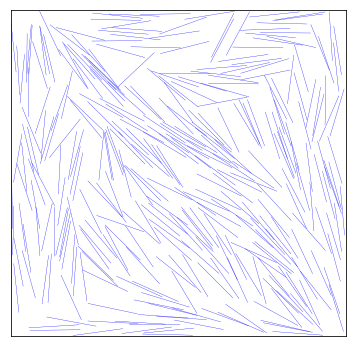

In [41]:
w = 20.
h = w
plt.plot()
plt.xlim(-w/2,w/2)
plt.ylim(-h/2,h/2)
plt.xticks([])
plt.yticks([])

# Read in data
fname = "save/confX/sweep_00085000"
dfile = open(fname, "r")
for line in dfile.readlines():
    l = line.split()
    plotLine(l[5],l[6],l[7],l[8])
    
plt.gcf().set_size_inches(6,6)
f = plt.gcf()


In [42]:
f.savefig(fname+".eps");